This idea of simplified representation refers to https://github.com/christophM/interpretable-ml-book/tree/master, which is conducted in R-Studio.

In [421]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt
import seaborn as sns

In [422]:
lower_x1, upper_x1 = -2, 2
lower_x2, upper_x2 = -2, 1
n_training = 20000
n_grid = 100
n_sample = 500
np.random.seed(1)

In [423]:
def get_y(x1, x2, noise_prob=0):
    y = np.sign(np.sign(x2 - 1.31 + np.abs(x1 * 1.1)) / 3 - np.sign(x2 - 0.3 + np.abs(x1 * 1.3)) / 3) + 1
    y = y * (1 - np.random.binomial(1, noise_prob, size=len(x1)))
    y = 1 - y 
    return y


In [424]:
x1 = np.random.uniform(lower_x1, upper_x1, n_training)
x2 = np.random.uniform(lower_x2, upper_x2, n_training)
y = get_y(x1, x2)
y_noisy = get_y(x1, x2, noise_prob=0.01)

In [425]:
lime_training_df = pd.DataFrame({'x1': x1, 'x2': x2, 'y': y, 'y_noisy': y_noisy})

In [426]:
rf = RandomForestClassifier(n_estimators=100, random_state= 1)
rf.fit(lime_training_df[['x1', 'x2']], lime_training_df['y_noisy'])
lime_training_df['predicted'] = rf.predict(lime_training_df[['x1', 'x2']])
explain_x1, explain_x2 = 0.75, 0.4
explain_point = np.array([explain_x1, explain_x2])
explain_y_model = rf.predict([explain_point])[0]
df_explain = pd.DataFrame({'x1': [explain_x1], 'x2': [explain_x2], 'y_predicted': [explain_y_model]})

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [427]:
x_means = [lime_training_df['x1'].mean(), lime_training_df['x2'].mean()]
x_sd = [lime_training_df['x1'].std(), lime_training_df['x2'].std()]

In [428]:
grid_x1 = np.linspace(lower_x1, upper_x1, n_grid)
grid_x2 = np.linspace(lower_x2, upper_x2, n_grid)
grid_df = pd.DataFrame([(x1, x2) for x1 in grid_x1 for x2 in grid_x2], columns=['x1', 'x2'])
grid_df['predicted'] = rf.predict(grid_df[['x1', 'x2']])

In [429]:
point_explain_scaled = (explain_point - x_means) / x_sd

x1_sample = np.random.normal(x_means[0], x_sd[0], n_sample)
x2_sample = np.random.normal(x_means[1], x_sd[1], n_sample)
df_sample = pd.DataFrame({'x1': x1_sample, 'x2': x2_sample})

In [430]:
points_sample_scaled = (df_sample - x_means) / x_sd

In [431]:
distances = euclidean_distances([point_explain_scaled], points_sample_scaled.values).flatten()
kernel_width = 0.145
weights = np.sqrt(np.exp(-(distances ** 2) / (kernel_width ** 2)))
df_sample['weights'] = weights
df_sample['predicted'] = rf.predict(df_sample[['x1', 'x2']])

In [432]:
local_model = LogisticRegression()
local_model.fit(df_sample[['x1', 'x2']], df_sample['predicted'], sample_weight=weights)
grid_df['explained'] = local_model.predict_proba(grid_df[['x1', 'x2']])[:, 1]

In [433]:
# Calculate the decision boundary of logistic regression
coefs = np.hstack((local_model.intercept_, local_model.coef_[0]))
logistic_boundary_x1 = grid_x1
logistic_boundary_x2 = -(coefs[0] + coefs[1] * logistic_boundary_x1) / coefs[2]

# Create a DataFrame to store the decision boundary
logistic_boundary_df = pd.DataFrame({'x1': logistic_boundary_x1, 'x2': logistic_boundary_x2})
logistic_boundary_df = logistic_boundary_df[(logistic_boundary_df['x2'] >= lower_x2) & 
                                            (logistic_boundary_df['x2'] <= upper_x2)]


In [434]:
#Create a smaller grid for visualizing local decision boundaries
x1_steps = np.linspace(lower_x1, upper_x1, 20)
x2_steps = np.linspace(lower_x2, upper_x2, 20)

grid_df_small = grid_df[
    grid_df['x1'].apply(lambda x: any(np.isclose(x, x1_steps, atol=1e-2))) &
    grid_df['x2'].apply(lambda x: any(np.isclose(x, x2_steps, atol=1e-2)))
].copy()

grid_df_small['explained_class'] = np.round(grid_df_small['explained'])

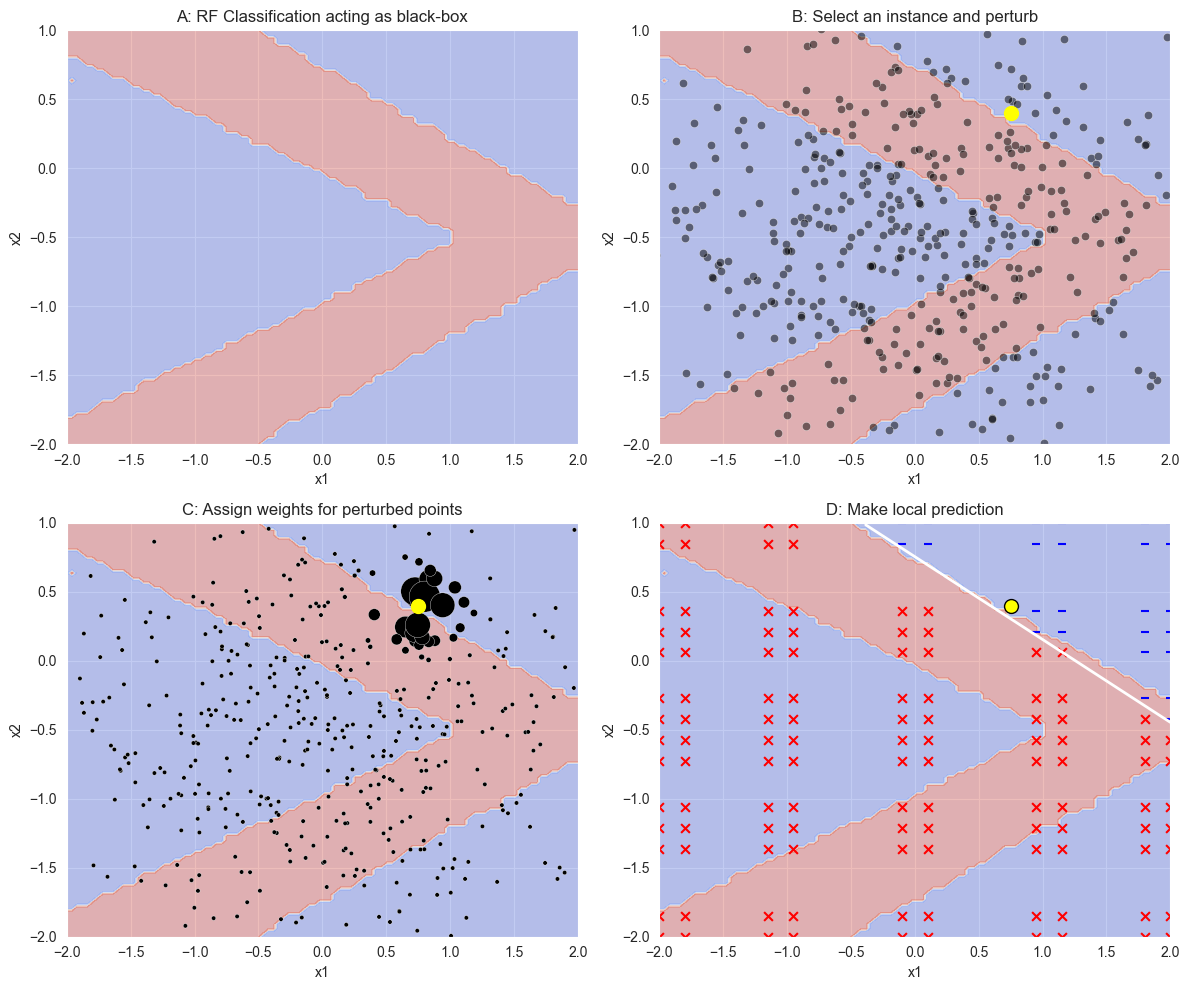

In [435]:

fig, axs = plt.subplots(2, 2, figsize=(12, 10))
#plotA: black box decision Boundary
plt.sca(axs[0, 0])
plt.title("A: RF Classification acting as black-box")
plt.contourf(grid_x1, grid_x2, grid_df['predicted'].values.reshape(n_grid, n_grid), alpha=0.35, cmap='coolwarm')
plt.xlim(-2, 2)
plt.ylim(-2, 1)
plt.xlabel("x1")
plt.ylabel("x2")

# Plot B: Adding sampled points and explanation points
plt.sca(axs[0, 1])
plt.title("B: Select an instance and perturb")
plt.contourf(grid_x1, grid_x2, grid_df['predicted'].values.reshape(n_grid, n_grid), alpha=0.35, cmap='coolwarm')
sns.scatterplot(x='x1', y='x2', data=df_sample, color='black', alpha=0.5)
plt.scatter(df_explain['x1'], df_explain['x2'], color='yellow', s=100, label='Explained Point')
plt.xlim(-2, 2)
plt.ylim(-2, 1)
plt.xlabel("x1")
plt.ylabel("x2")

# plot C: Sample Weight Distribution
plt.sca(axs[1, 0])
plt.title("C: Assign weights for perturbed points")
plt.contourf(grid_x1, grid_x2, grid_df['predicted'].values.reshape(n_grid, n_grid), alpha=0.35, cmap='coolwarm')
sns.scatterplot(x='x1', y='x2', size='weights', data=df_sample, sizes=(10, 500), legend=False, color='black')
plt.scatter(df_explain['x1'], df_explain['x2'], color='yellow', s=100, label='Explained Point')
plt.xlim(-2, 2)
plt.ylim(-2, 1)
plt.xlabel("x1")
plt.ylabel("x2")

## plotD: Decision Boundary of the Local Model Explanation
plt.sca(axs[1, 1])
plt.title("D: Make local prediction")
#black box boundary
plt.contourf(
    grid_x1, grid_x2,
    grid_df['predicted'].values.reshape(n_grid, n_grid),
    alpha=0.35, cmap='coolwarm')

#+ and -
plt.scatter(
    grid_df_small[grid_df_small['explained_class'] == 1]['x1'],
    grid_df_small[grid_df_small['explained_class'] == 1]['x2'],
    color='red', marker='x', s=40, label='Local Class 1'
)
plt.scatter(
    grid_df_small[grid_df_small['explained_class'] == 0]['x1'],
    grid_df_small[grid_df_small['explained_class'] == 0]['x2'],
    color='blue', marker='_', s=40, label='Local Class 0'
)

#instance point
plt.scatter(
    df_explain['x1'], df_explain['x2'],
    color='yellow', edgecolor='black', s=100, label='Explained Point'
)

# Decision Boundary of Logistic Regression
plt.plot(
    logistic_boundary_df['x1'], logistic_boundary_df['x2'],
    color='white', linewidth=2, label='Logistic Boundary'
)
plt.xlim(-2, 2)
plt.ylim(-2, 1)
plt.xlabel("x1")
plt.ylabel("x2")

plt.tight_layout() 
plt.savefig("results/algo.png") 
plt.show()